In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import sentence_transformers
import hdbscan
import umap

# Data Exploration

In [9]:
df = pd.read_csv('../Data/data_job_posts.csv')

df.dropna(inplace=True, subset=['JobDescription', 'JobRequirment', 'RequiredQual'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13142 entries, 0 to 19000
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   jobpost           13142 non-null  object
 1   date              13142 non-null  object
 2   Title             13124 non-null  object
 3   Company           13142 non-null  object
 4   AnnouncementCode  849 non-null    object
 5   Term              5970 non-null   object
 6   Eligibility       3242 non-null   object
 7   Audience          408 non-null    object
 8   StartDate         6995 non-null   object
 9   Duration          8098 non-null   object
 10  Location          13136 non-null  object
 11  JobDescription    13142 non-null  object
 12  JobRequirment     13142 non-null  object
 13  RequiredQual      13142 non-null  object
 14  Salary            7190 non-null   object
 15  ApplicationP      13142 non-null  object
 16  OpeningDate       12844 non-null  object
 17  Deadline         

# Vectorise

In [115]:
from sentence_transformers import SentenceTransformer

test = ['this is an example sentence', 'each sentence is converted']

# model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')  # better quality but slower
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')  # more general but faster
embeddings = model.encode(test)

.gitattributes: 100%|██████████| 1.18k/1.18k [00:00<00:00, 3.49MB/s]
1_Pooling/config.json: 100%|██████████| 190/190 [00:00<00:00, 459kB/s]
README.md: 100%|██████████| 10.6k/10.6k [00:00<00:00, 28.1MB/s]
config_sentence_transformers.json: 100%|██████████| 116/116 [00:00<00:00, 386kB/s]
data_config.json: 100%|██████████| 39.3k/39.3k [00:00<00:00, 17.9MB/s]
pytorch_model.bin: 100%|██████████| 90.9M/90.9M [00:14<00:00, 6.29MB/s]
sentence_bert_config.json: 100%|██████████| 53.0/53.0 [00:00<00:00, 179kB/s]
special_tokens_map.json: 100%|██████████| 112/112 [00:00<00:00, 599kB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 8.11MB/s]
tokenizer_config.json: 100%|██████████| 350/350 [00:00<00:00, 930kB/s]
train_script.py: 100%|██████████| 13.2k/13.2k [00:00<00:00, 28.7MB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 1.56MB/s]
modules.json: 100%|██████████| 349/349 [00:00<00:00, 1.13MB/s]


## Vectorise Job Data

In [274]:
jobdata = df[['Title', 'JobDescription', 'JobRequirment', 'RequiredQual']].drop_duplicates()
jobtext = jobdata[['JobRequirment', 'RequiredQual']].values.tolist()
# jobtext = df[['JobRequirment']].values.tolist()

def clean_text(text):
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
    return text

jobtext = [[clean_text(text) for text in job] for job in jobtext]
jobtext = [' '.join(job) for job in jobtext]
jobtext = np.array(jobtext)
# np.random.shuffle(jobtext)
jobtext.shape

(12396,)

In [363]:
embeddings = model.encode(jobtext, show_progress_bar=True)

Batches: 100%|██████████| 388/388 [15:42<00:00,  2.43s/it]


In [365]:
np.savetxt('../Data/embeddings.csv', embeddings, delimiter=',')

In [305]:
from sklearn.cluster import DBSCAN

clusterer = DBSCAN(eps=0.1, min_samples=2)
clusterer.fit(embeddings)

DBSCAN(eps=0.1, min_samples=2)

In [356]:
%time umap_embeddings = umap.UMAP(n_components=2, n_neighbors=50, min_dist=0.5).fit_transform(embeddings)

CPU times: user 34.5 s, sys: 857 ms, total: 35.3 s
Wall time: 7.29 s


In [357]:
clusterer = DBSCAN(min_samples=2, eps=0.1)
clusterer.fit(umap_embeddings)

DBSCAN(eps=0.1, min_samples=2)

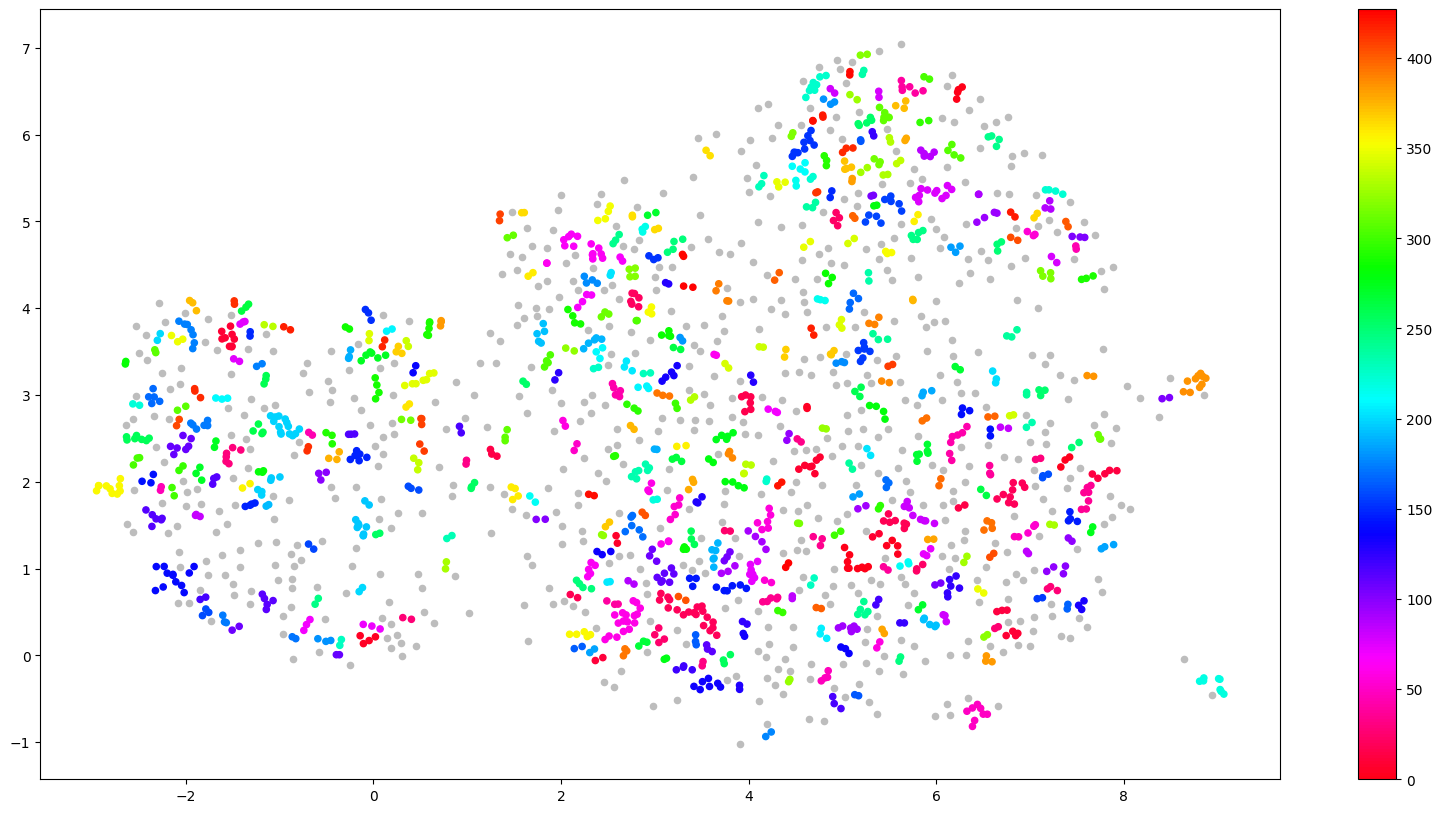

In [358]:
fig, ax = plt.subplots(figsize=(20, 10))
outliers = umap_embeddings[clusterer.labels_ == -1]
clustered = umap_embeddings[clusterer.labels_ != -1]
plt.scatter(outliers[:, 0], outliers[:, 1], color='#BDBDBD', s=20)
plt.scatter(clustered[:, 0], clustered[:, 1], c=clusterer.labels_[clusterer.labels_ != -1], s=20, cmap='hsv_r')
plt.colorbar()

# plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=clusterer.labels_, s=5, cmap='Spectral')

In [359]:
print(len(np.unique(clusterer.labels_)))
pd.Series(clusterer.labels_).value_counts()[:10]

429


-1      643
 19      19
 60      17
 197     14
 76      11
 354     10
 153     10
 1        9
 225      9
 20       9
Name: count, dtype: int64

In [360]:
# get index where value is 14
indexes = np.where(clusterer.labels_ == 19)
indexes

(array([  23,   46,   50,   55,   76,  269,  323,  568,  751,  788,  850,
        1026, 1215, 1317, 1330, 1508, 1531, 1550, 1565]),)

In [361]:
jobdata.iloc[indexes]['Title']

64                   Administrative Assistant/ Secretary
99                              Administrative Assistant
104                Language and Administrative Assistant
116       Assistant to Director, Translator/ Interpreter
151                             Administrative Assistant
484                        Receptionist/ Admin Assistant
596                          Website Moderator Assistant
1074                                           Secretary
1463                               Administrative Intern
1536                                  Secretary-Referent
1647                                           Secretary
1984                               Assistant/ Translator
2294                  Library Circulation Desk Assistant
2468                  Assistant to the General Secretary
2485                            Administrative Secretary
2817                                      Office Manager
2859        Specialist on Management Document Processing
2897                           

In [362]:
jobtext[indexes]

array([' To welcome visitors To organize and follow up switches between Sisian base and Yerevan To organize transmit and follow up all phone and fax communications in the base To organize appointments and visits in the base To make all copies required for the team To maintain office supply To do written and oral translation English Armenian Armenian English To perform other duties as required   Minimum two years relevant professional experience Good sense of organisating Good knowledge of computer Word Excel Fluent in English Russian Good communication skills ',
       'Duties will include but are not limited to Managing the general operations of the office Writing proposals and letters Developing texts for web site Answering phone calls Setting up meetings etc   University degree preferably majoring in English language Excellent writing skills Strong interpersonal and presentation skills Fluency in Armenian English and Russian Working experience as an Administrative Assistant is prefe

# TF-IDF